In [27]:
import numpy as np
import matplotlib.pyplot as plt
from math import *   # 引入pi, cos等
import cmath
import time
import functools  # 使用偏函数functools.partial()


def hamiltonian(k1, k2, M, t1, t2, phi, a=1/sqrt(3)):  # Haldane哈密顿量(a为原子间距，不赋值的话默认为1/sqrt(3)）
    # 初始化为零矩阵
    h0 = np.zeros((2, 2))*(1+0j)   # 乘(1+0j)是为了把h0转为复数
    h1 = np.zeros((2, 2))*(1+0j)
    h2 = np.zeros((2, 2))*(1+0j)

    # 质量项(mass term), 用于打开带隙
    h0[0, 0] = M
    h0[1, 1] = -M

    # 最近邻项
#     h1[1, 0] = t1*(cmath.exp(1j*k2*a)+cmath.exp(1j*sqrt(3)/2*k1*a-1j/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j/2*k2*a))
#     h1[0, 1] = h1[1, 0].conj()
    h1[1, 0] = t1*(cmath.exp(1j*k2*a)+2*cmath.cos(0.5*sqrt(3)*k1*a)*cmath.exp(-1j*0.5*k2*a))
    h1[0, 1] = t1*(cmath.exp(-1j*k2*a)+2*cmath.cos(0.5*sqrt(3)*k1*a)*cmath.exp(1j*0.5*k2*a))
    #次近邻项 # 对应陈数为-1
#     h2[0, 0] = t2*cmath.exp(-1j*phi)*(cmath.exp(1j*sqrt(3)*k1*a)+cmath.exp(-1j*sqrt(3)/2*k1*a+1j*3/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j*3/2*k2*a))
#     h2[1, 1] = t2*cmath.exp(1j*phi)*(cmath.exp(1j*sqrt(3)*k1*a)+cmath.exp(-1j*sqrt(3)/2*k1*a+1j*3/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j*3/2*k2*a))
    h2[0, 0] = -2*t2*(-cmath.cos(phi+sqrt(3)*k1*a)-2*cmath.cos(3/2*k2*a)*cmath.cos(phi-0.5*sqrt(3)*k1*a))
    h2[1, 1] = 2*t2*(cmath.cos(phi-sqrt(3)*k1*a)+2*cmath.cos(3/2*k2*a)*cmath.cos(phi+0.5*sqrt(3)*k1*a))
    
    # # 次近邻项  # 对应陈数为1
    # h2[0, 0] = t2*cmath.exp(1j*phi)*(cmath.exp(1j*sqrt(3)*k1*a)+cmath.exp(-1j*sqrt(3)/2*k1*a+1j*3/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j*3/2*k2*a))
    # h2[1, 1] = t2*cmath.exp(-1j*phi)*(cmath.exp(1j*sqrt(3)*k1*a)+cmath.exp(-1j*sqrt(3)/2*k1*a+1j*3/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j*3/2*k2*a))

    matrix = h0 + h1 + h2
    return matrix


def main():
    start_clock = time.perf_counter()
    delta = 0.005
    chern_number = 0  # 陈数初始化
    
    # 几个坐标中常出现的项
    a = 1/sqrt(3)
    aa1 = 4*sqrt(3)*pi/9/a
    aa2 = 2*sqrt(3)*pi/9/a
    bb1 = 2*pi/3/a

    hamiltonian0 = functools.partial(hamiltonian, M=2/3, t1=1, t2=1/3, phi=pi/4, a=a)   # 使用偏函数，固定一些参数

    for kx in np.arange(-aa1, aa1, delta):
        print(kx)
        for ky in np.arange(-bb1, bb1, delta):
            if (-aa2<=kx<=aa2) or (kx>aa2 and -(aa1-kx)*tan(pi/3)<=ky<=(aa1-kx)*tan(pi/3)) or (kx<-aa2 and  -(kx-(-aa1))*tan(pi/3)<=ky<=(kx-(-aa1))*tan(pi/3)):  # 限制在六角格子布里渊区内

                H = hamiltonian0(kx, ky) 
                eigenvalue, eigenvector = np.linalg.eig(H)
                vector = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 价带波函数
            
                H_delta_kx = hamiltonian0(kx+delta, ky) 
                eigenvalue, eigenvector = np.linalg.eig(H_delta_kx)
                vector_delta_kx = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]   # 略偏离kx的波函数

                H_delta_ky = hamiltonian0(kx, ky+delta)  
                eigenvalue, eigenvector = np.linalg.eig(H_delta_ky)
                vector_delta_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 略偏离ky的波函数
                
                H_delta_kx_ky = hamiltonian0(kx+delta, ky+delta)  
                eigenvalue, eigenvector = np.linalg.eig(H_delta_kx_ky)
                vector_delta_kx_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 略偏离kx和ky的波函数
                
                Ux = np.dot(np.conj(vector), vector_delta_kx)/abs(np.dot(np.conj(vector), vector_delta_kx))
                Uy = np.dot(np.conj(vector), vector_delta_ky)/abs(np.dot(np.conj(vector), vector_delta_ky))
                Ux_y = np.dot(np.conj(vector_delta_ky), vector_delta_kx_ky)/abs(np.dot(np.conj(vector_delta_ky), vector_delta_kx_ky))
                Uy_x = np.dot(np.conj(vector_delta_kx), vector_delta_kx_ky)/abs(np.dot(np.conj(vector_delta_kx), vector_delta_kx_ky))

                F = cmath.log(Ux*Uy_x*(1/Ux_y)*(1/Uy))

                # 陈数(chern number)
                chern_number = chern_number + F

    chern_number = chern_number/(2*pi*1j)
    print('Chern number = ', chern_number)
    end_clock = time.perf_counter()
    print('CPU执行时间(min)=', (end_clock-start_clock)/60)


if __name__ == '__main__':
    main()

-4.1887902047863905
-4.183790204786391
-4.178790204786391
-4.173790204786391
-4.168790204786391
-4.163790204786391
-4.158790204786391
-4.153790204786391
-4.148790204786391
-4.1437902047863915
-4.138790204786392
-4.133790204786392
-4.128790204786392
-4.123790204786392
-4.118790204786392
-4.113790204786392
-4.108790204786392
-4.103790204786392
-4.098790204786392
-4.0937902047863926
-4.088790204786393
-4.083790204786393
-4.078790204786393
-4.073790204786393
-4.068790204786393
-4.063790204786393
-4.058790204786393
-4.053790204786393
-4.0487902047863935
-4.043790204786394
-4.038790204786394
-4.033790204786394
-4.028790204786394
-4.023790204786394
-4.018790204786394
-4.013790204786394
-4.008790204786394
-4.0037902047863945
-3.9987902047863946
-3.9937902047863947
-3.988790204786395
-3.983790204786395
-3.978790204786395
-3.973790204786395
-3.968790204786395
-3.9637902047863953
-3.9587902047863954
-3.9537902047863955
-3.9487902047863956
-3.9437902047863957
-3.938790204786396
-3.933790204786396


-2.0837902047864354
-2.0787902047864355
-2.0737902047864356
-2.0687902047864357
-2.063790204786436
-2.058790204786436
-2.053790204786436
-2.048790204786436
-2.0437902047864362
-2.0387902047864364
-2.0337902047864365
-2.0287902047864366
-2.0237902047864367
-2.018790204786437
-2.013790204786437
-2.008790204786437
-2.003790204786437
-1.9987902047864372
-1.9937902047864373
-1.9887902047864374
-1.9837902047864375
-1.9787902047864376
-1.9737902047864377
-1.9687902047864378
-1.963790204786438
-1.958790204786438
-1.9537902047864382
-1.9487902047864383
-1.9437902047864384
-1.9387902047864385
-1.9337902047864386
-1.9287902047864387
-1.9237902047864388
-1.918790204786439
-1.913790204786439
-1.9087902047864391
-1.9037902047864392
-1.8987902047864393
-1.8937902047864394
-1.8887902047864396
-1.8837902047864397
-1.8787902047864398
-1.8737902047864399
-1.86879020478644
-1.86379020478644
-1.8587902047864402
-1.8537902047864403
-1.8487902047864404
-1.8437902047864405
-1.8387902047864406
-1.8337902047864

-0.0287902047864792
-0.023790204786479308
-0.018790204786479414
-0.01379020478647952
-0.008790204786479627
-0.003790204786479734
0.0012097952135201595
0.006209795213520053
0.011209795213519946
0.01620979521351984
0.021209795213519733
0.026209795213519627
0.03120979521351952
0.03620979521351941
0.04120979521351931
0.0462097952135192
0.051209795213519094
0.05620979521351899
0.06120979521351888
0.06620979521351877
0.07120979521351867
0.07620979521351856
0.08120979521351845
0.08620979521351835
0.09120979521351824
0.09620979521351813
0.10120979521351803
0.10620979521351792
0.11120979521351781
0.11620979521351771
0.1212097952135176
0.1262097952135175
0.1312097952135174
0.13620979521351728
0.14120979521351718
0.14620979521351707
0.15120979521351696
0.15620979521351686
0.16120979521351675
0.16620979521351664
0.17120979521351654
0.17620979521351643
0.18120979521351632
0.18620979521351622
0.1912097952135161
0.196209795213516
0.2012097952135159
0.2062097952135158
0.21120979521351568
0.21620979521

2.126209795213475
2.1312097952134748
2.1362097952134746
2.1412097952134745
2.1462097952134744
2.1512097952134743
2.1562097952134742
2.161209795213474
2.166209795213474
2.171209795213474
2.176209795213474
2.1812097952134737
2.1862097952134736
2.1912097952134735
2.1962097952134734
2.2012097952134733
2.206209795213473
2.211209795213473
2.216209795213473
2.221209795213473
2.2262097952134727
2.2312097952134726
2.2362097952134725
2.2412097952134724
2.2462097952134723
2.251209795213472
2.256209795213472
2.261209795213472
2.266209795213472
2.2712097952134718
2.2762097952134717
2.2812097952134716
2.2862097952134715
2.2912097952134713
2.2962097952134712
2.301209795213471
2.306209795213471
2.311209795213471
2.316209795213471
2.3212097952134707
2.3262097952134706
2.3312097952134705
2.3362097952134704
2.3412097952134703
2.34620979521347
2.35120979521347
2.35620979521347
2.36120979521347
2.3662097952134697
2.3712097952134696
2.3762097952134695
2.3812097952134694
2.3862097952134693
2.391209795213469


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import *   # 引入pi, cos等
import cmath
import time
import functools  # 使用偏函数functools.partial()


def hamiltonian(k1, k2, M, t1, t2, phi, a=1):  # Haldane哈密顿量(a为原子间距，不赋值的话默认为1/sqrt(3)）
    # 初始化为零矩阵
    h0 = np.zeros((2, 2))*(1+0j)   # 乘(1+0j)是为了把h0转为复数
    h1 = np.zeros((2, 2))*(1+0j)
    h2 = np.zeros((2, 2))*(1+0j)

    # 质量项(mass term), 用于打开带隙
    h0[0, 0] = M
    h0[1, 1] = -M

    # 最近邻项
#     h1[1, 0] = t1*(cmath.exp(1j*k2*a)+cmath.exp(1j*sqrt(3)/2*k1*a-1j/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j/2*k2*a))
#     h1[0, 1] = h1[1, 0].conj()
    h1[1, 0] = t1*(cmath.exp(1j*k2*a)+2*cmath.cos(0.5*sqrt(3)*k1*a)*cmath.exp(-1j*0.5*k2*a))
    h1[0, 1] = t1*(cmath.exp(-1j*k2*a)+2*cmath.cos(0.5*sqrt(3)*k1*a)*cmath.exp(1j*0.5*k2*a))
    #次近邻项 # 对应陈数为-1
#     h2[0, 0] = t2*cmath.exp(-1j*phi)*(cmath.exp(1j*sqrt(3)*k1*a)+cmath.exp(-1j*sqrt(3)/2*k1*a+1j*3/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j*3/2*k2*a))
#     h2[1, 1] = t2*cmath.exp(1j*phi)*(cmath.exp(1j*sqrt(3)*k1*a)+cmath.exp(-1j*sqrt(3)/2*k1*a+1j*3/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j*3/2*k2*a))
    h2[0, 0] = -2*t2*(-cmath.cos(phi+sqrt(3)*k1*a)-2*cmath.cos(3/2*k2*a)*cmath.cos(phi-0.5*sqrt(3)*k1*a))
    h2[1, 1] = 2*t2*(cmath.cos(phi-sqrt(3)*k1*a)+2*cmath.cos(3/2*k2*a)*cmath.cos(phi+0.5*sqrt(3)*k1*a))
    
    # # 次近邻项  # 对应陈数为1
    # h2[0, 0] = t2*cmath.exp(1j*phi)*(cmath.exp(1j*sqrt(3)*k1*a)+cmath.exp(-1j*sqrt(3)/2*k1*a+1j*3/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j*3/2*k2*a))
    # h2[1, 1] = t2*cmath.exp(-1j*phi)*(cmath.exp(1j*sqrt(3)*k1*a)+cmath.exp(-1j*sqrt(3)/2*k1*a+1j*3/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j*3/2*k2*a))

    matrix = h0 + h1 + h2
    return matrix


def main():
    start_clock = time.perf_counter()
    delta = 0.002
    chern_number = 0  # 陈数初始化
    
    # 常出现的项
    a = 1
    bb1 = 2*sqrt(3)*pi/3/a
    bb2 = 2*pi/3/a

    hamiltonian0 = functools.partial(hamiltonian, M=1, t1=1, t2=1/3, phi=pi/4, a=a)   # 使用偏函数，固定一些参数

    for k1 in np.arange(0 , 1, delta):
        print(k1)
        for k2 in np.arange(0, 1, delta):
            # 坐标变换
            kx = (k1-k2)*bb1
            ky = (k1+k2)*bb2

            # 这里乘2或除以2是为了保证“步长与积分个数的乘积刚好为布里渊区面积”
            delta_x = delta*bb1*2    
            delta_y = delta*bb2*2/2

            H = hamiltonian0(kx, ky) 
            eigenvalue, eigenvector = np.linalg.eig(H)
            vector = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 价带波函数
        
            H_delta_kx = hamiltonian0(kx+delta_x, ky) 
            eigenvalue, eigenvector = np.linalg.eig(H_delta_kx)
            vector_delta_kx = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]   # 略偏离kx的波函数

            H_delta_ky = hamiltonian0(kx, ky+delta_y)  
            eigenvalue, eigenvector = np.linalg.eig(H_delta_ky)
            vector_delta_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 略偏离ky的波函数
            
            H_delta_kx_ky = hamiltonian0(kx+delta_x, ky+delta_y)  
            eigenvalue, eigenvector = np.linalg.eig(H_delta_kx_ky)
            vector_delta_kx_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 略偏离kx和ky的波函数
            
            Ux = np.dot(np.conj(vector), vector_delta_kx)/abs(np.dot(np.conj(vector), vector_delta_kx))
            Uy = np.dot(np.conj(vector), vector_delta_ky)/abs(np.dot(np.conj(vector), vector_delta_ky))
            Ux_y = np.dot(np.conj(vector_delta_ky), vector_delta_kx_ky)/abs(np.dot(np.conj(vector_delta_ky), vector_delta_kx_ky))
            Uy_x = np.dot(np.conj(vector_delta_kx), vector_delta_kx_ky)/abs(np.dot(np.conj(vector_delta_kx), vector_delta_kx_ky))

            F = cmath.log(Ux*Uy_x*(1/Ux_y)*(1/Uy))
            # 陈数(chern number)
            chern_number = chern_number + F

    chern_number = chern_number/(2*pi*1j)
    print('Chern number = ', chern_number)
    end_clock = time.perf_counter()
    print('CPU执行时间(min)=', (end_clock-start_clock)/60)


if __name__ == '__main__':
    main()

0.0
0.002
0.004
0.006
0.008
0.01
0.012
0.014
0.016
0.018000000000000002
0.02
0.022
0.024
0.026000000000000002
0.028
0.03
0.032
0.034
0.036000000000000004
0.038
0.04
0.042
0.044
0.046
0.048
0.05
0.052000000000000005
0.054
0.056
0.058
0.06
0.062
0.064
0.066
0.068
0.07
0.07200000000000001
0.074
0.076
0.078
0.08
0.082
0.084
0.08600000000000001
0.088
0.09
0.092
0.094
0.096
0.098
0.1
0.10200000000000001
0.10400000000000001
0.106
0.108
0.11
0.112
0.114
0.116
0.11800000000000001
0.12
0.122
0.124
0.126
0.128
0.13
0.132
0.134
0.136
0.138
0.14
0.14200000000000002
0.14400000000000002
0.146
0.148
0.15
0.152
0.154
0.156
0.158
0.16
0.162
0.164
0.166
0.168
0.17
0.17200000000000001
0.17400000000000002
0.176
0.178
0.18
0.182
0.184
0.186
0.188
0.19
0.192
0.194
0.196
0.198
0.2
0.202
0.20400000000000001
0.20600000000000002
0.20800000000000002
0.21
0.212
0.214
0.216
0.218
0.22
0.222
0.224
0.226
0.228
0.23
0.232
0.234
0.23600000000000002
0.23800000000000002
0.24
0.242
0.244
0.246
0.248
0.25
0.252
0.254
0.256

In [26]:
import numpy as np
x = np.array([4, 2, 1])
np.argsort(x)

array([2, 1, 0], dtype=int64)

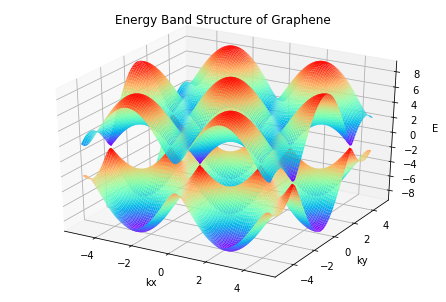

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
#a=0.15nm,γ = 3ev
from mpl_toolkits.mplot3d import Axes3D  #绘制3D坐标的函数
fig1 = plt.figure() #创建一个函数对象
ax = Axes3D(fig1) #用绘图对象创建一个axes的对象（3D坐标）
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
x,y = np.meshgrid(x,y)

def fun(x,y):
	a = 4.0*np.cos(np.sqrt(3)/2*1.5*x)*np.cos(1.5/2*y)
	b = 4.0*np.cos(1.5*y/2)*np.cos(1.5*y/2)
	c1 = 3*np.sqrt(1+a+b)
	c2 = (-1)*3*np.sqrt(1+a+b)
	return c1, c2

z1, z2 = fun(x,y)
ax.plot_surface(x, y, z1, rstride = 1, cstride = 1, cmap = plt.get_cmap('rainbow'))
ax.plot_surface(x, y, z2, rstride = 1, cstride = 1, cmap = plt.get_cmap('rainbow'))
#stride行之间的跨度，cstride是列之间的跨度，cmp是颜色表
ax.set_xlabel('kx', fontsize = 10)
ax.set_ylabel('ky', fontsize = 10)
ax.set_zlabel('E', fontsize = 10)
ax.set_title('Energy Band Structure of Graphene')
plt.savefig("石墨烯.jpg")
plt.show()
# ax.set_zlim(-10,10)

# import os
# os.system('pip install --upgrade matplotlib --user')使用三维坐标函数时调用库的需求
# ————————————————
# 版权声明：本文为CSDN博主「è¤è²çåºå­」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/weixin_43405448/java/article/details/89441820

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *   # 引入pi, cos等
import cmath
import time
import functools  # 使用偏函数functools.partial()


def hamiltonian(k1, k2, M, t1, t2, phi, a=1):  # Haldane哈密顿量(a为原子间距，不赋值的话默认为1/sqrt(3)）
    # 初始化为零矩阵
    h0 = np.zeros((2, 2))*(1+0j)   # 乘(1+0j)是为了把h0转为复数
    h1 = np.zeros((2, 2))*(1+0j)
    h2 = np.zeros((2, 2))*(1+0j)

    # 质量项(mass term), 用于打开带隙
    h0[0, 0] = M
    h0[1, 1] = -M

    # 最近邻项
#     h1[1, 0] = t1*(cmath.exp(1j*k2*a)+cmath.exp(1j*sqrt(3)/2*k1*a-1j/2*k2*a)+cmath.exp(-1j*sqrt(3)/2*k1*a-1j/2*k2*a))
#     h1[0, 1] = h1[1, 0].conj()
    h1[1, 0] = t1*(cmath.exp(1j*k2*a)+2*cmath.cos(0.5*sqrt(3)*k1*a)*cmath.exp(-1j*0.5*k2*a))
    h1[0, 1] = t1*(cmath.exp(-1j*k2*a)+2*cmath.cos(0.5*sqrt(3)*k1*a)*cmath.exp(1j*0.5*k2*a))
    
#     次近邻项

#     对应陈数为1
#     h2[0, 0] = -2*t2*(-cmath.cos(phi+sqrt(3)*k1*a)-2*cmath.cos(3/2*k2*a)*cmath.cos(phi-0.5*sqrt(3)*k1*a))
#     h2[1, 1] = 2*t2*(cmath.cos(phi-sqrt(3)*k1*a)+2*cmath.cos(3/2*k2*a)*cmath.cos(phi+0.5*sqrt(3)*k1*a))
    
#     对应陈数为-1
    h2[0, 0] = -2*t2*(-cmath.cos(-phi+sqrt(3)*k1*a)-2*cmath.cos(3/2*k2*a)*cmath.cos(-phi-0.5*sqrt(3)*k1*a))
    h2[1, 1] = 2*t2*(cmath.cos(-phi-sqrt(3)*k1*a)+2*cmath.cos(3/2*k2*a)*cmath.cos(-phi+0.5*sqrt(3)*k1*a))
  
    matrix = h0 + h1 + h2
    return matrix


def main():
    start_clock = time.perf_counter()
    delta = 0.002
    chern_number = 0  # 陈数初始化
    
    # 常出现的项
    a = 1
    bb1 = 2*sqrt(3)*pi/3/a
    bb2 = 2*pi/3/a

    hamiltonian0 = functools.partial(hamiltonian, M=1, t1=1, t2=1/3, phi=pi/4, a=a)   # 使用偏函数，固定一些参数

    for k1 in np.arange(0 , 1, delta):
        print(k1)
        for k2 in np.arange(0, 1, delta):
            # 坐标变换
            kx = (k1-k2)*bb1
            ky = (k1+k2)*bb2

            # 这里乘2或除以2是为了保证“步长与积分个数的乘积刚好为布里渊区面积”
            delta_x = delta*bb1*2    
            delta_y = delta*bb2*2/2

            H = hamiltonian0(kx, ky) 
            eigenvalue, eigenvector = np.linalg.eig(H)
            vector = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 价带波函数
        
            H_delta_kx = hamiltonian0(kx+delta_x, ky) 
            eigenvalue, eigenvector = np.linalg.eig(H_delta_kx)
            vector_delta_kx = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]   # 略偏离kx的波函数

            H_delta_ky = hamiltonian0(kx, ky+delta_y)  
            eigenvalue, eigenvector = np.linalg.eig(H_delta_ky)
            vector_delta_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 略偏离ky的波函数
            
            H_delta_kx_ky = hamiltonian0(kx+delta_x, ky+delta_y)  
            eigenvalue, eigenvector = np.linalg.eig(H_delta_kx_ky)
            vector_delta_kx_ky = eigenvector[:, np.argsort(np.real(eigenvalue))[0]]  # 略偏离kx和ky的波函数
            
            Ux = np.dot(np.conj(vector), vector_delta_kx)/abs(np.dot(np.conj(vector), vector_delta_kx))
            Uy = np.dot(np.conj(vector), vector_delta_ky)/abs(np.dot(np.conj(vector), vector_delta_ky))
            Ux_y = np.dot(np.conj(vector_delta_ky), vector_delta_kx_ky)/abs(np.dot(np.conj(vector_delta_ky), vector_delta_kx_ky))
            Uy_x = np.dot(np.conj(vector_delta_kx), vector_delta_kx_ky)/abs(np.dot(np.conj(vector_delta_kx), vector_delta_kx_ky))

            F = cmath.log(Ux*Uy_x*(1/Ux_y)*(1/Uy))
            # 陈数(chern number)
            chern_number = chern_number + F

    chern_number = chern_number/(2*pi*1j)
    print('Chern number = ', chern_number)
    end_clock = time.perf_counter()
    print('CPU执行时间(min)=', (end_clock-start_clock)/60)


if __name__ == '__main__':
    main()

0.0
0.002
0.004
0.006
0.008
0.01
0.012
0.014
0.016
0.018000000000000002
0.02
0.022
0.024
0.026000000000000002
0.028
0.03
0.032
0.034
0.036000000000000004
0.038
0.04
0.042
0.044
0.046
0.048
0.05
0.052000000000000005
0.054
0.056
0.058
0.06
0.062
0.064
0.066
0.068
0.07
0.07200000000000001
0.074
0.076
0.078
0.08
0.082
0.084
0.08600000000000001
0.088
0.09
0.092
0.094
0.096
0.098
0.1
0.10200000000000001
0.10400000000000001
0.106
0.108
0.11
0.112
0.114
0.116
0.11800000000000001
0.12
0.122
0.124
0.126
0.128
0.13
0.132
0.134
0.136
0.138
0.14
0.14200000000000002
0.14400000000000002
0.146
0.148
0.15
0.152
0.154
0.156
0.158
0.16
0.162
0.164
0.166
0.168
0.17
0.17200000000000001
0.17400000000000002
0.176
0.178
0.18
0.182
0.184
0.186
0.188
0.19
0.192
0.194
0.196
0.198
0.2
0.202
0.20400000000000001
0.20600000000000002
0.20800000000000002
0.21
0.212
0.214
0.216
0.218
0.22
0.222
0.224
0.226
0.228
0.23
0.232
0.234
0.23600000000000002
0.23800000000000002
0.24
0.242
0.244
0.246
0.248
0.25
0.252
0.254
0.256